# Регуляризация линейной регрессии

*Разминка*: Всегда ли решение задачи линейной регрессии единственно?
- единственное, если признаки независимы


*Вопрос*: А если все же линейной зависимости нет? Подсказка: решение задачи регрессии имеет вид. $(X^TX)^{-1}X^Ty$.
 

*Вопрос*: К чему это приведет?


*Вопрос:* Какие еще последствия у мультиколлинеарности?

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_diabetes, fetch_openml,load_iris,fetch_california_housing

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

np.random.seed(42)

# Переобучение
В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не \"вытащив\" из данных никакой закономерности, от нее будет мало толку. Такую модель называют *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.\n",

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого нам понадобится сгенерировать синтетические данные. Рассмотрим зависимость $y = cos(1.5\pi x)$, 
 $y $ — целевая переменная, а $x$ - объект (в нашем случае это число от 0 до 1). В жизни мы наблюдаем какое-то конечное количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек  $x_i, y_i$  в отрезке $[0, 1]$.

В реальной жизни целевая переменная может быть зашумленной, смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой - $\{x\}$, для второй - $\{x, x^2, x^3, x^4\}$, для третьей - $\{x, \dots, x^{20}\}$.
    

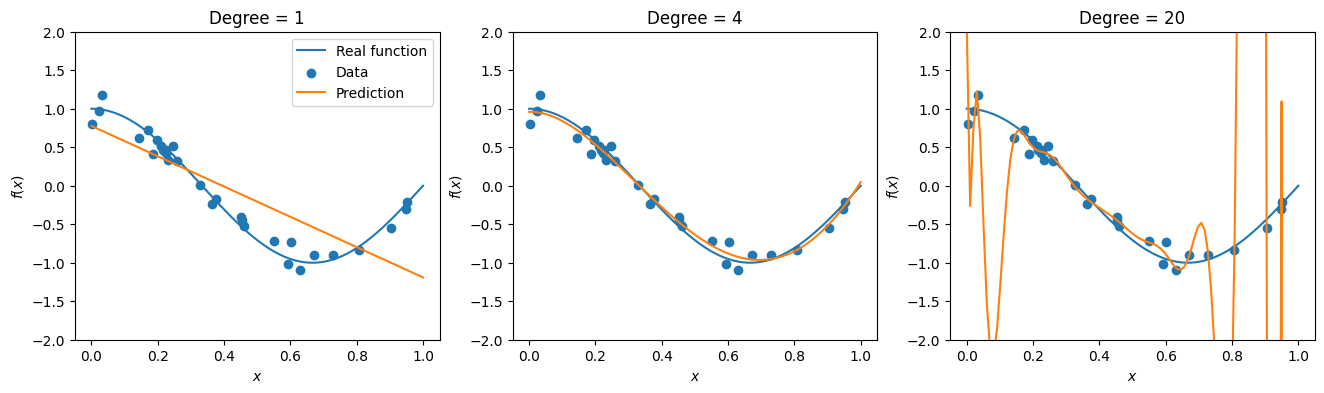

In [30]:
np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

from sklearn.preprocessing import PolynomialFeatures
fig, ax = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree, include_bias=False).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x[:, None])
    model = LinearRegression().fit(X_objects, y_objects)
    y_pred = model.predict(X)
    ax[i].plot(x, y, label="Real function")
    ax[i].scatter(x_objects, y_objects, label="Data")
    ax[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        ax[i].legend()
    ax[i].set_title("Degree = %d" % degree)
    ax[i].set_xlabel("$x$")
    ax[i].set_ylabel("$f(x)$")
    ax[i].set_ylim(-2, 2)

**Вопрос**: Почему первая модель получилась плохой, а третья переобучилась?

Чтобы избежать переобучения, модель регуляризуют. На этом занятии мы как раз рассмотрим различные методы регуляризации линейных моделей.

Но, прежде, чем начать, создадим свою версию линейной модели, которую можно инициализировать готовыми весами и не обучать на данных. Зачем нам это понадобится? Узнаем чуть позже.
Итак, создайте класс линейной модели, которую можно будет инициализировать заданными коэффициентами. Она должна реализовывать интерфейс модели sklearn. Можете отнаследоваться от стандартной линейной модели.

In [31]:
class LinearPredictionModel(LinearRegression):
    def __init__(self, coef=None, intercept=None):
        if coef is not None:
            coef = np.array(coef)
            if intercept is None:
                intercept = np.zeros(coef.shape[0])
            else:
                intercept = np.array(intercept)
            assert coef.shape[0] == intercept.shape[0]
        else:
            if intercept is not None:
                raise ValueError("Provide coef only or both coef and intercept")
        self.intercept_ = intercept
        self.coef_ = coef


Для первых экспериментов также создадим случайный набор данных, где x имеет 2 признака. Можете обучить свою или стандартную модель на этих данных.

In [32]:
x = np.random.randn(5,2)
real_alpha = 1.5
real_beta = 2.
y = real_alpha * x[:, 0] + real_beta * x[:, 1] + np.random.normal(loc=0., scale=0.2)
model = LinearRegression().fit(x, y)
print(f"coefficients: {model.coef_}, intercept: {model.intercept_}")

coefficients: [1.5 2. ], intercept: -0.012552218819650074


Создадим функцию, которая будет сохранять значение ошибки для разных значений параметров. Функция должна возвращать датафрейм со столбцами `["a", "b", "error"]`.

In [33]:
def get_errors_table(
    alphas: list[float] | NDArray, betas: list[float] | NDArray, x: NDArray, y: NDArray
) -> pd.DataFrame:
    result = pd.DataFrame(columns=["a", "b", "error"])
    for alpha in alphas:
        for beta in betas:
            res = {"a": alpha, "b": beta}
            model = LinearPredictionModel(coef=[[alpha, beta]], intercept=[[0]])
            res["error"] = mean_squared_error(model.predict(x), y)
            result = pd.concat([result, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)
    return result
            

Зададим сетку параметров:

In [34]:
alphas = np.linspace(real_alpha - 2, real_alpha + 2, 101)
betas = np.linspace(real_beta - 2, real_beta + 2, 101)


In [35]:
alphas

array([-0.5 , -0.46, -0.42, -0.38, -0.34, -0.3 , -0.26, -0.22, -0.18,
       -0.14, -0.1 , -0.06, -0.02,  0.02,  0.06,  0.1 ,  0.14,  0.18,
        0.22,  0.26,  0.3 ,  0.34,  0.38,  0.42,  0.46,  0.5 ,  0.54,
        0.58,  0.62,  0.66,  0.7 ,  0.74,  0.78,  0.82,  0.86,  0.9 ,
        0.94,  0.98,  1.02,  1.06,  1.1 ,  1.14,  1.18,  1.22,  1.26,
        1.3 ,  1.34,  1.38,  1.42,  1.46,  1.5 ,  1.54,  1.58,  1.62,
        1.66,  1.7 ,  1.74,  1.78,  1.82,  1.86,  1.9 ,  1.94,  1.98,
        2.02,  2.06,  2.1 ,  2.14,  2.18,  2.22,  2.26,  2.3 ,  2.34,
        2.38,  2.42,  2.46,  2.5 ,  2.54,  2.58,  2.62,  2.66,  2.7 ,
        2.74,  2.78,  2.82,  2.86,  2.9 ,  2.94,  2.98,  3.02,  3.06,
        3.1 ,  3.14,  3.18,  3.22,  3.26,  3.3 ,  3.34,  3.38,  3.42,
        3.46,  3.5 ])

In [36]:
df = get_errors_table(alphas, betas, x, y)

Нарисуйте поверхность функции потерь в 3d. Для отрисовки удобнее всего воспользовать функцией `plot_trisurf`. Для создания графика можно воспользоваться `fig.add_subplot(subplot_pos (int: n_hor|n_vert|position), projection='3d')`

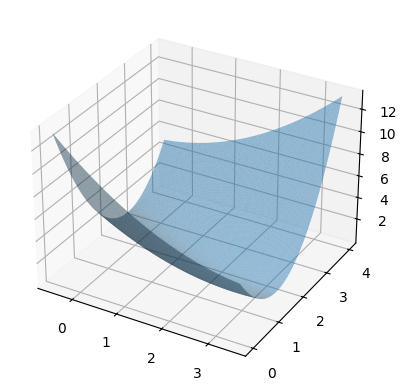

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Один способ нарисовать 3d график
x1 = np.linspace(df['a'].min(), df['a'].max(), len(df['a'].unique()))
y1 = np.linspace(df['b'].min(), df['b'].max(), len(df['b'].unique()))
x2, y2 = np.meshgrid(x1, y1) 

z2 = griddata((df['a'], df['b']), df['error'], (x2, y2), method='cubic')
ax.plot_trisurf(df["a"], df["b"], df["error"], alpha=0.5)
plt.show()

Также можно нарисовать линии уровня для этой поверхности. Можно воспользоваться функцией `ax.tricontour`.

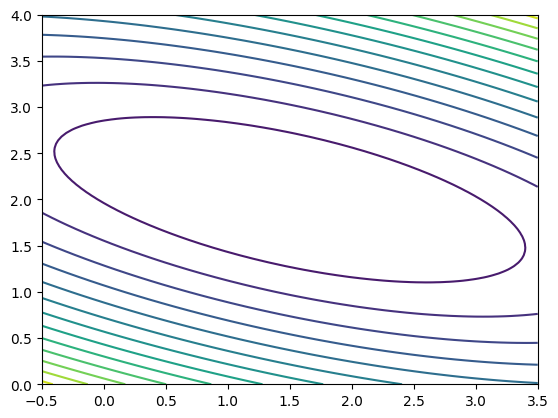

In [38]:
fig, ax = plt.subplots()
CS = ax.tricontour(df['a'], df['b'], df['error'], levels=15 )

Отлично! Теперь можно переходить к вопросам регуляризации. 

Вместо исходной задачи можно решать другую, с учетом регуляризации:
\begin{equation}
\min_w L(f, X, y) = \min_w(|X w - y|_2^2 + \lambda |w|^k_k ),
\end{equation}
где 
\begin{equation}
|w|^2_2 = w^2_1 + \ldots + w^2_n
\end{equation}
\begin{equation}
|w|_1^1 = \vert w_1 \vert + \ldots + \vert w_n \vert
\end{equation}

Коэффициент $\lambda$ - коэффициент регуляризации, его часто подбирают по логарифмической шкале.


Вопрос: Нужно ли регуляризовать отступ?

Решение новой задачи (L2) имеет вид 
\begin{equation} 
w = (X^TX + \lambda I)^{-1}X^Ty
\end{equation}
В случае плохо обусловленной матрицы можно сразу увидеть эффект от регуляризации. Какой?
Градиент же имеет вид
\begin{equation}
\nabla_wL(f_w, X, y) = 2X^T(Xw - y) + 2\lambda w
\end{equation}

Вопрос: Какой вариант градиентного спуска правильный для батча размера N:
\begin{equation}
(a) w_i\mapsto w_i - 2\alpha(\langle w, x_j\rangle - y_j)x_{ji} - \frac{2\alpha\lambda}N w_i,\quad i=1,\ldots,D
\end{equation}
\begin{equation}
(b) w_i\mapsto w_i - 2\alpha(\langle w, x_j\rangle - y_j)x_{ji} - 2\alpha\lambda w_i,\quad i=1,\ldots,D
\end{equation}
\begin{equation}
(c) w_i\mapsto w_i - 2\alpha(\langle w, x_j\rangle - y_j)x_{ji} - 2\lambda N w_i,\quad i=1,\ldots D
\end{equation}


Вопрос: Как выглядит градиент в случае L1- регуляризации? 

Вопрос: А как быть в точке, где градиента не существует?

Вопрос: Можно ли применить регуляризацию для другой функции потерь?

Теперь попробуем геометрически отрисовать, как выглядят составляющие функции потерь после регуляризации. Для начала реализуем функции рассчета нормы.

In [39]:
import math
import numpy as np
def l1_norm(vector):
    return sum(abs(x) for x in vector) # Make a l1 norm regularizer for vector

def l2_norm(vector):
    return math.sqrt(sum(x**2 for x in vector)) # Make a l2 norm regularizer for vector

def p_norm(vector, p: float=1.):
    return sum(abs(x)**p for x in vector)**(1/p)  # Make a lp norm regularizer for vector

Зададим пространство параметров, как и ранее, но построим таблицу норм весов вместо ошибок.

In [40]:
alphas = np.linspace( - 2, real_alpha + 2, 101)
betas = np.linspace( - 2, real_beta + 2, 101)

def get_norm_plot(alphas, betas, norm_fn):
    result = pd.DataFrame(columns=["a", "b", "norm"])
    for alpha in alphas:
        for beta in betas:
            res = {"a": alpha, "b": beta}
            res["norm"] = norm_fn(np.array([alpha, beta]))
            result = pd.concat([result, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)
    return result
            

In [41]:
df_norm = get_norm_plot(alphas, betas, l1_norm)

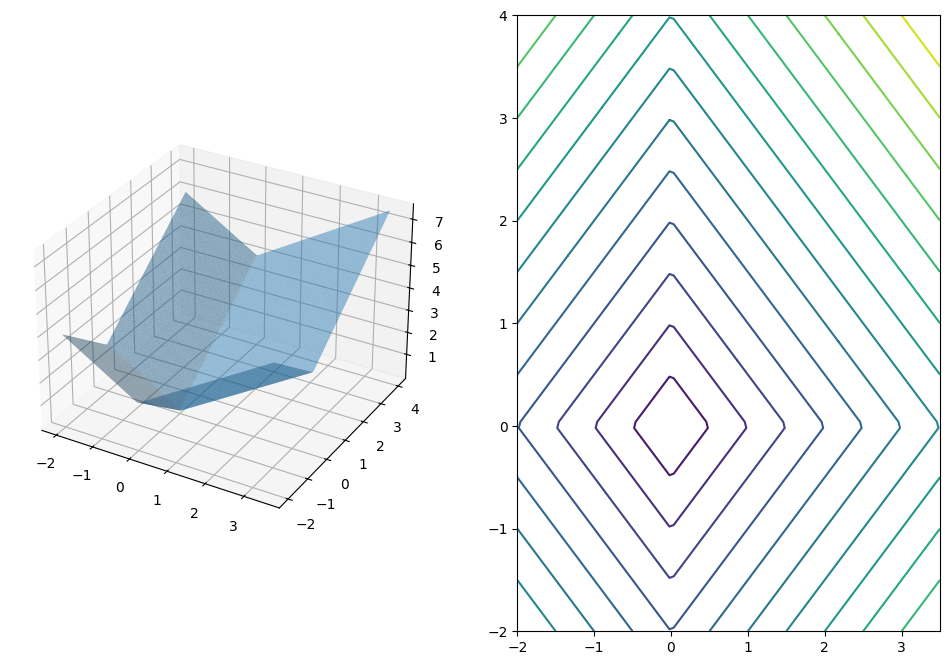

In [42]:

fig = plt.figure(figsize=(12,8))
ax_1 = fig.add_subplot(121, projection='3d')
ax_2 = fig.add_subplot(122)

# Interpolate unstructured D-dimensional data.
ax_1.plot_trisurf(df_norm["a"], df_norm["b"], df_norm["norm"], alpha=0.5)
ax_2.tricontour(df_norm['a'], df_norm['b'], df_norm['norm'], levels=15 )
plt.show()

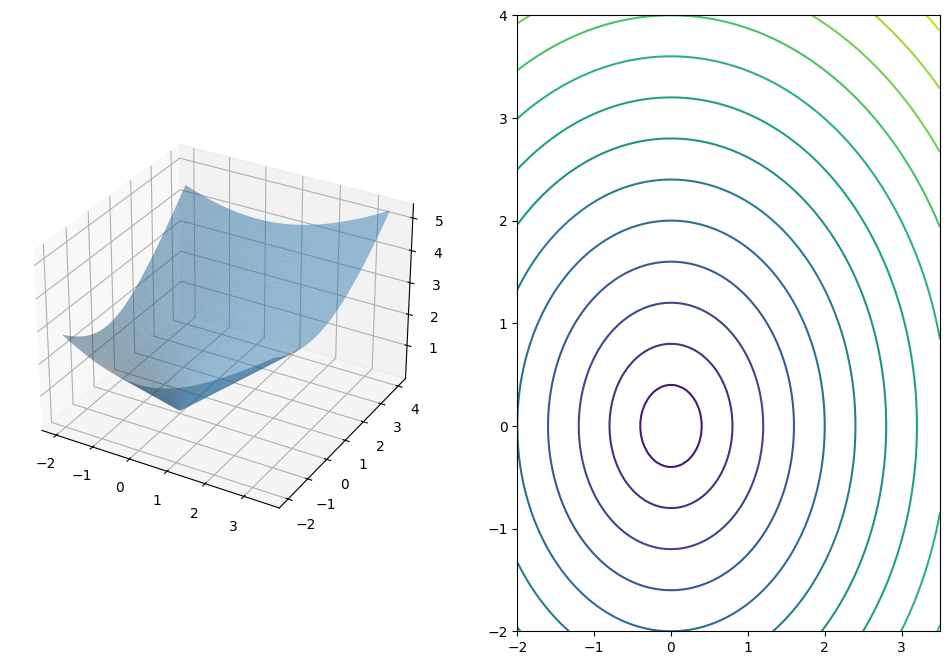

In [43]:
df_norm = get_norm_plot(alphas, betas, l2_norm)

fig = plt.figure(figsize=(12,8))
ax_1 = fig.add_subplot(121, projection='3d')
ax_2 = fig.add_subplot(122)

# Interpolate unstructured D-dimensional data.
ax_1.plot_trisurf(df_norm["a"], df_norm["b"], df_norm["norm"], alpha=0.5)
ax_2.tricontour(df_norm['a'], df_norm['b'], df_norm['norm'], levels=15 )
plt.show()

Вопрос: Что будет с поверхностью, если строить график для регулязированной функции ошибки?

Чтобы проверить свой ответ, построим его. Для этого реализуйте функцию для рассчета новой ошибки (с функцией регуляризации как параметром)

In [44]:
def get_error_plot(alphas, betas, norm_fn, gamma, x, y):
    result = pd.DataFrame(columns=["a", "b", "error"])
    for alpha in alphas:
        for beta in betas:
            res = {"a": alpha, "b": beta}
            model = LinearPredictionModel(coef=[[alpha, beta]], intercept=[[0]])# Make a linear model with given coefficients. Use intercept 0 
            res["error"] = mean_squared_error(model.predict(x), y) + gamma * norm_fn(np.array([alpha, beta]))
            result = pd.concat([result, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)
    return result
            
            

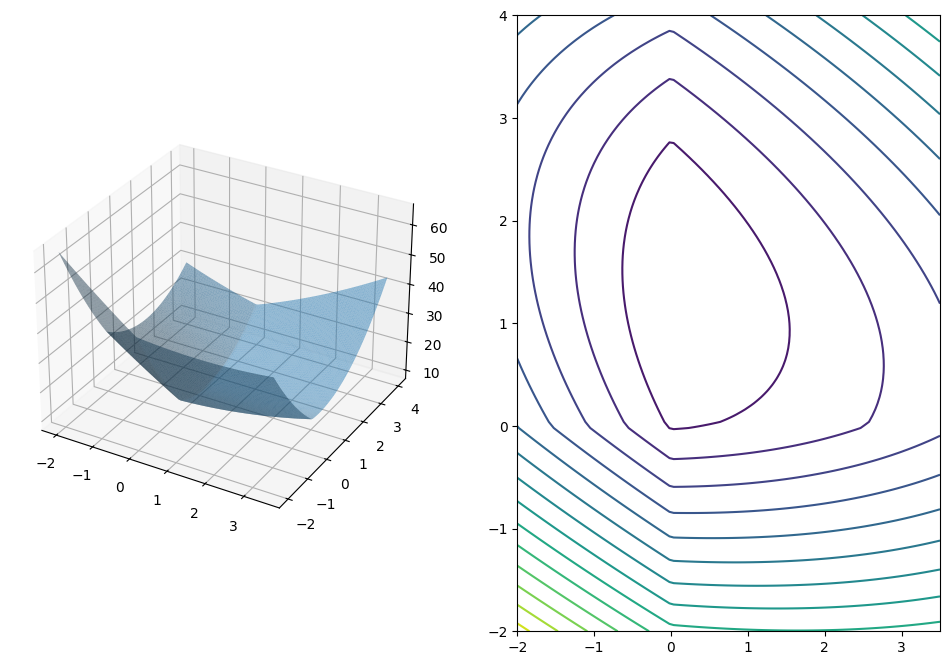

In [45]:
alphas = np.linspace( - 2, real_alpha + 2, 101)
betas = np.linspace( - 2, real_beta + 2, 101)
df_norm = get_error_plot(alphas, betas, l1_norm, 4., x, y)

fig = plt.figure(figsize=(12,8))
ax_1 = fig.add_subplot(121, projection='3d')
ax_2 = fig.add_subplot(122)

ax_1.plot_trisurf(df_norm["a"], df_norm["b"], df_norm["error"], alpha=0.5)
ax_2.tricontour(df_norm['a'], df_norm['b'], df_norm['error'], levels=15)
plt.show()

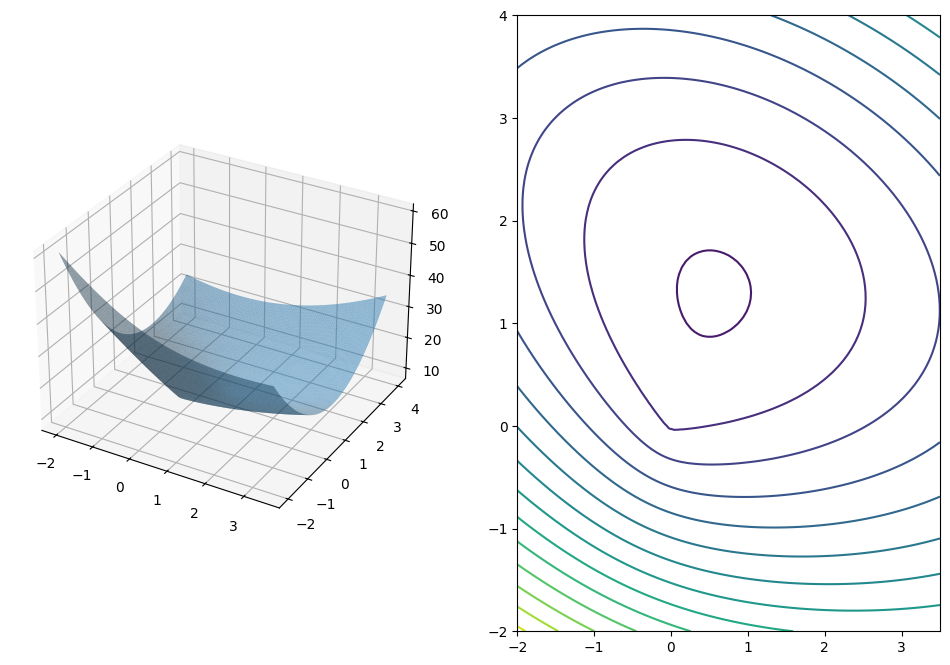

In [46]:
alphas = np.linspace( - 2, real_alpha + 2, 101)
betas = np.linspace( - 2, real_beta + 2, 101)
df_norm = get_error_plot(alphas, betas, l2_norm, 4., x, y)

fig = plt.figure(figsize=(12,8))
ax_1 = fig.add_subplot(121, projection='3d')
ax_2 = fig.add_subplot(122)

ax_1.plot_trisurf(df_norm["a"], df_norm["b"], df_norm["error"], alpha=0.5)
ax_2.tricontour(df_norm['a'], df_norm['b'], df_norm['error'], levels=15)
plt.show()

**Вопрос 1**: Почему большие веса в линейной модели — плохо?

**Вопрос 2**: Почему регуляризовать $w_0$
 — плохая идея?
 
**Вопрос 3**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если его
 начать уменьшать? Что будет, если его сделать слишком большим?

## Спарсность при использовании L1

У L1-регрессии есть еще одно замечательное свойство. Оно заключается в том, что оптимальное решение в случае задачи с ограничениями находится в точке пересечения с основной поверхностью. Это будет происходить в углах ромба, где один из весов занулен. В результате, при увеличении размерности, у признаков, не оказывающих влияния на ответы, веса постепенно зануляются.
Таким образом, этот вид регрессии тоже можно использовать для выбора признаков.

*Вопрос:* Может быть задача, при которой спарсность не будет наблюдаться?

Для иллютрации рассмотрим уже знакомый датасет по классификации цифр. Однако, для нужд регрессии сделаем таргет, равный "яркости" написания - суммы всех значений пикселей.

In [48]:
mnist = fetch_openml('mnist_784', cache=False)

X = mnist["data"].astype('float64')
X.reset_index()
y_c = mnist["target"].astype('int64')
y_c.reset_index()

print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y_c.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


In [49]:
y = X.sum(axis=1) + X.iloc[:,0:20].sum(axis=1) * 2 + X.iloc[:,100:400].sum(axis=1) * 1.5

In [50]:
random_indices = np.random.choice(X.index, 10000, replace=False)
X_rus = X.loc[random_indices]
y_rus = y.loc[random_indices]

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=0)


In [53]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_[3], model.intercept_)

-1.0336592331679064 -5.093170329928398e-11


<Axes: ylabel='Density'>

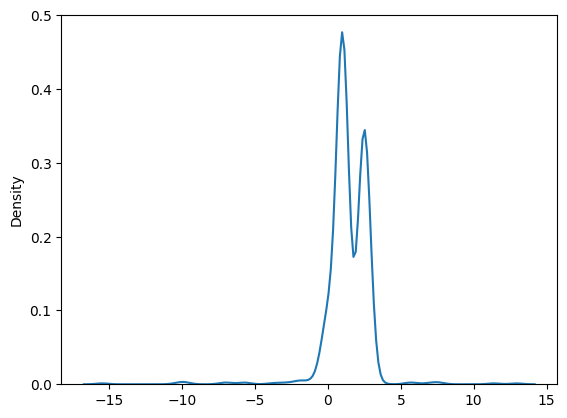

In [54]:
sns.kdeplot(model.coef_)

0.0 0.928441050586116


<Axes: ylabel='Density'>

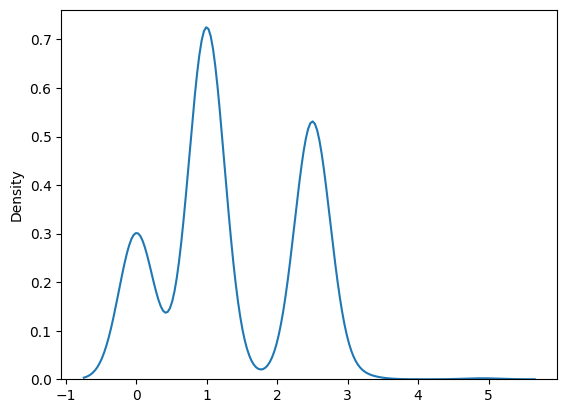

In [55]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(alpha=1.)
lasso.fit(X_train, y_train)
print(lasso.coef_[3], lasso.intercept_)
sns.kdeplot(lasso.coef_)

Увеличим значение регуляризации

0.0 3.5431433897902025


<Axes: ylabel='Density'>

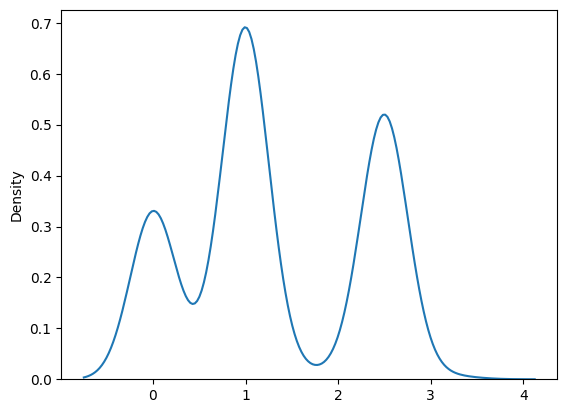

In [56]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(alpha=4.)
lasso.fit(X_train, y_train)
print(lasso.coef_[3], lasso.intercept_)
sns.kdeplot(lasso.coef_)

0.0 15.504394137948111


<Axes: ylabel='Density'>

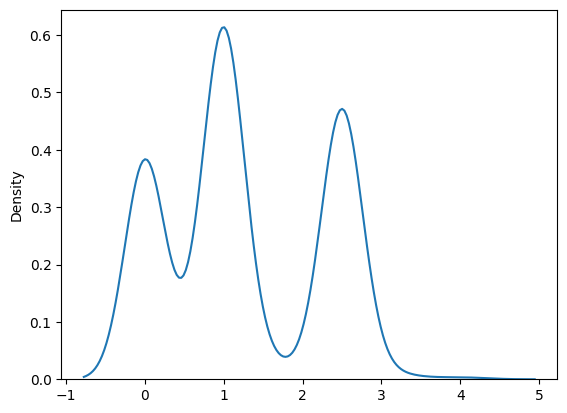

In [57]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(alpha=20.)
lasso.fit(X_train, y_train)
print(lasso.coef_[3], lasso.intercept_)
sns.kdeplot(lasso.coef_)

Как видно, чем больше параметр регуляризации, тем больше весов уходит в ноль.

0.0 -0.0002424054400762543


<Axes: ylabel='Density'>

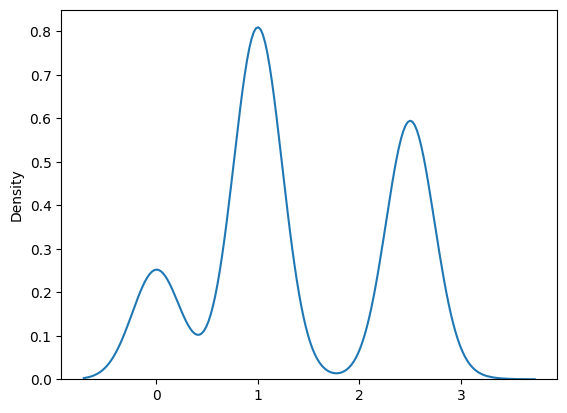

In [58]:
from sklearn.linear_model import Lasso, Ridge
model = Ridge()
model.fit(X_train, y_train)
print(model.coef_[3], model.intercept_)
sns.kdeplot(model.coef_)

Посмотрим, будем ли мы наблюдать такой же эффект в случае Ridge регрессии. 

0.0 -0.0009291085079894401


<Axes: ylabel='Density'>

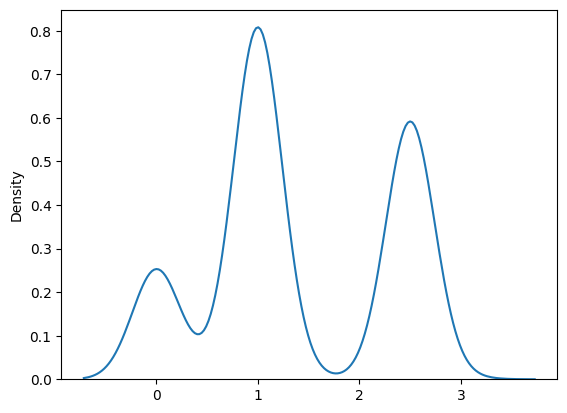

In [59]:
# Make the same eexperiment with alpha=5
from sklearn.linear_model import Lasso, Ridge
model = Ridge(alpha=5.)
model.fit(X_train, y_train)
print(model.coef_[3], model.intercept_)
sns.kdeplot(model.coef_)

0.0 -0.0009745947245392017


<Axes: ylabel='Density'>

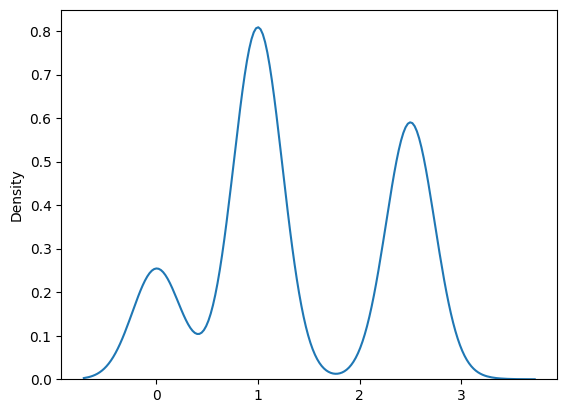

In [60]:
# Make the same eexperiment with alpha=20
from sklearn.linear_model import Lasso, Ridge
model = Ridge(alpha=20.)
model.fit(X_train, y_train)
print(model.coef_[3], model.intercept_)
sns.kdeplot(model.coef_)

Как видно, в данном случае это не наблюдается. Кстати, это можно понять и по геометрическому представлению L2-регуляризации. 

Какой из видов регуляризации выбрать? 
Часто решение зависит от задачи.

Так, L2-регрессия больше внимания уделяет большим весам, а вот относительно маленькие будут в низком приоритете. Почему?

Также спарсность - очень полезное свойство. Однако иногда L1 регрессия проигрывает L1. Почему?

Кроме того:
- В случае p>n L1 выбирает не более n переменных до насыщения из-за природы задачи выпуклой оптимизации.
- Если существует группа переменных, среди которых попарные корреляции очень высоки, то L1 стремится выбрать только одну переменную из группы, и ей все равно, какую именно
- Для обычных n>p ситуаций, если существуют высокие корреляции между предикторами,эмпирически замечено, что в предсказательной производительности L2 доминирует над L1

## Elastic Net
Эта модель была предложена как способ исправить проблемы первых двух пунктов, но при этом достичь лучших рещультатов, чем Lasso, в целом.
Она устроена на удивление просто, как комбинация первых двух, и практически всегда будет хорошим решением. Единственная проблема в том, что в ее случае приходится тюнить сразу два параметра:
\begin{equation}
\min_w L(f, X, y) = \min_w(|X w - y|_2^2 + \lambda_1 |w|^2_2 + \lambda_2 |w|_1),
\end{equation}

0.0 1.1550575452565681


<Axes: ylabel='Density'>

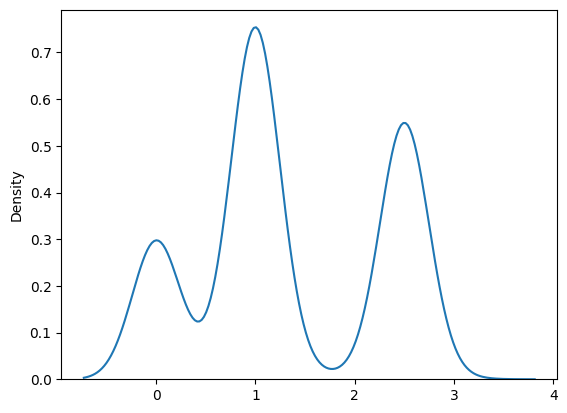

In [61]:
## Elastic Net
from sklearn.linear_model import ElasticNet
# Make the same eexperiment as for ridge and lasso with alpha=5
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=1)
model.fit(X_train, y_train)
print(model.coef_[3], model.intercept_)
sns.kdeplot(model.coef_)

В данном случае мы наблюдаем смешанный эффект. 

## Задача

**Задание**. Протестируйте разные методы регуляризации на наборе данных из начала занятия.

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e-01, tolerance: 3.306e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e-01, tolerance: 3.306e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e-01, toleranc

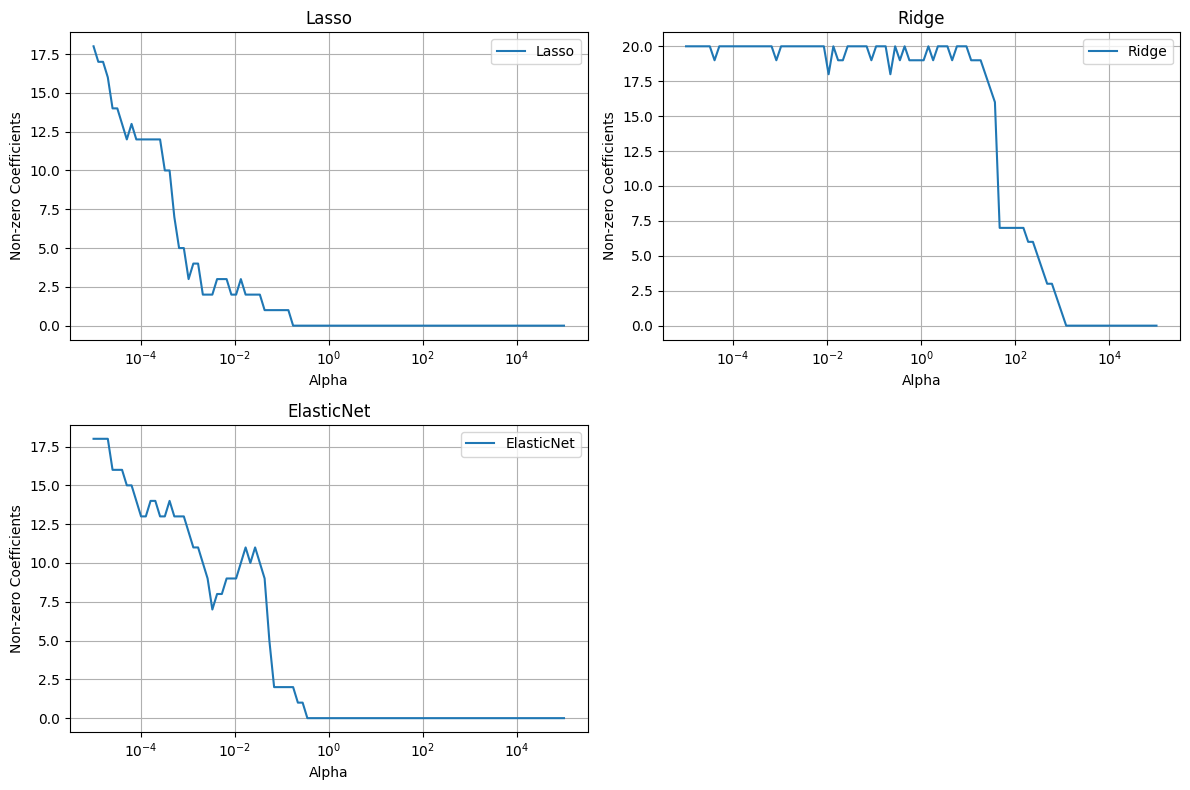

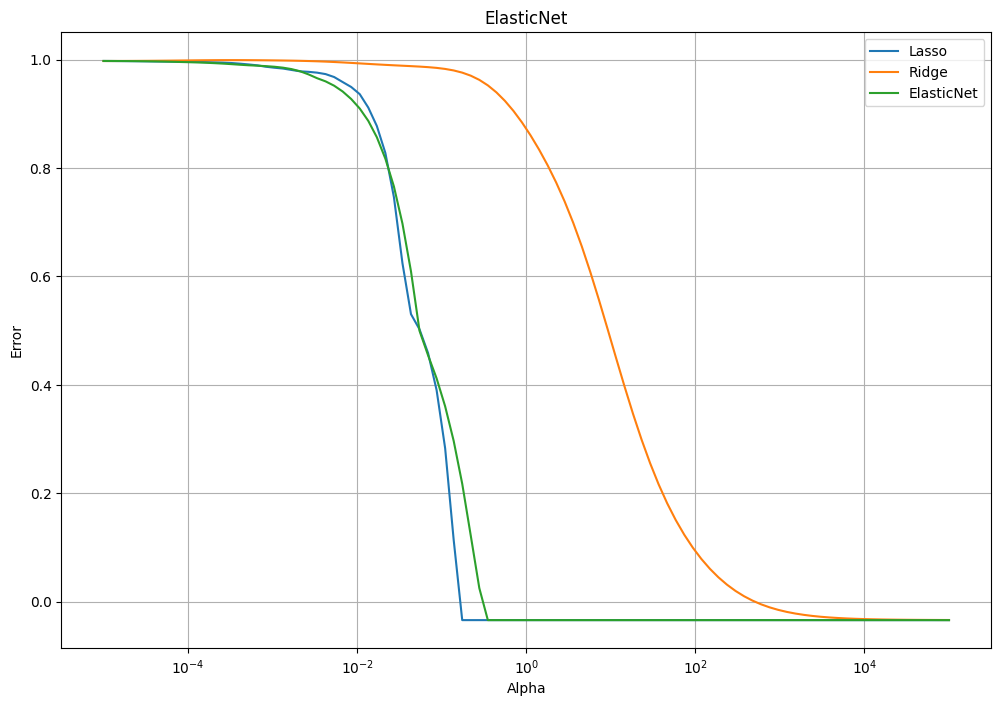

In [ ]:
###########
# 
# YOUR CODE
# 1) make a regression data
# 1) make a linear model with degree = 20
# 2) Try lasso, ridge and elastic net regression with at least two or three different alphas
# 3) Draw the plot: on one axis (three plots in one) show the sparsity level for different lambdas of each regularizer
# 4) Draw the plot (or make table): show the error for different lambdas of each regularizer
#
###########

np.random.seed(42)
x= np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=70)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

alphas = np.logspace(-5, 5, 100)
l1_ratio = np.linspace(0, 1, 10)

models = {
    "Lasso": Lasso,
    "Ridge": Ridge,
    "ElasticNet": ElasticNet
}
results = {
    'Lasso': {'coefficients': None, 'errors': None},
    'Ridge': {'coefficients': None, 'errors': None},
    'ElasticNet': {'coefficients': None, 'errors': None}
}

X_objects = PolynomialFeatures(20, include_bias=False).fit_transform(x_objects[:, None])
X = PolynomialFeatures(20, include_bias=False).fit_transform(x[:, None])

# 2) Try lasso, ridge and elastic net regression with at least two or three different alphas
for model_name, model_class in models.items():
    for alpha in alphas:
        model = model_class(alpha=alpha)  # Create an instance of the model class
        model.fit(X_objects, y_objects)
        
        if results[model_name]['coefficients'] is None:
            results[model_name]['coefficients'] = [model.coef_]
        else:
            results[model_name]['coefficients'].append(model.coef_)
        if results[model_name]['errors'] is None:
            results[model_name]['errors'] = [model.score(X, y)]
        else:
            results[model_name]['errors'].append(model.score(X, y))
            
# Count non-zero coefficients for each alpha
for model_name, res in results.items():
    res['coefficients'] = np.array(res['coefficients'])
    non_zero_counts = np.sum(np.abs(res['coefficients']) > 0.01, axis=1)
    res['non_zero_counts'] = non_zero_counts

# 3) Draw the plot: on one axis (three plots in one) show the sparsity level for different lambdas of each regularizer
# 4) Draw the plot (or make table): show the error for different lambdas of each regularizer
plt.figure(figsize=(12, 8))
for i, (model_name, res) in enumerate(results.items()):
    plt.subplot(2, 2, i + 1)
    plt.plot(alphas, res['non_zero_counts'], label=model_name)
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Non-zero Coefficients')
    plt.title(model_name)
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))
for model_name, res in results.items():
    plt.plot(alphas, res['errors'], label=model_name)
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Error')
plt.title(model_name)
plt.grid()
plt.legend()
plt.show()






# Классификация
Конечно, для классификации также можно использовать регуляризацию. Рассмотрим логистическую регрессию как последовательность из линейной модели и сигмоиды. Напишите функцию для получения ошибки, как раньше, но используя новую модель.

In [125]:

X = mnist["data"].astype('float64')
X.reset_index()
y_c = mnist["target"].astype('int64')
y_c.reset_index()

,index,class
0,0,5
1,1,0
2,2,4
3,3,1
4,4,9
...,...,...
69995,69995,2
69996,69996,3
69997,69997,4
69998,69998,5


In [126]:

def sigmoid(z):
    return 1/(1+(np.exp((-z))))

from sklearn.metrics import log_loss

def get_error_plot_sigmoid(alphas, betas, norm_fn, gamma, x, y):
    result = pd.DataFrame(columns=["a", "b", "error"])
    for alpha in alphas:
        for beta in betas:
            res = {"a": alpha, "b": beta}
            model = LinearPredictionModel(coef=[[alpha, beta]], intercept=[[0]])
            res["error"] = mean_squared_error(y, sigmoid(model.predict(x))) + gamma * norm_fn(np.array([alpha, beta]))
            result = pd.concat([result, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)
    return result
            
            

In [127]:
from sklearn.linear_model import LogisticRegression

x = np.random.randn(30,2)
real_alpha = 1.5
real_beta = 2.
line = real_alpha * x[:, 0] + real_beta * x[:, 1] 
y = (line + np.random.normal(loc=0, scale=0.5, size=x.shape[0]) > line).astype(int)
model = LogisticRegression().fit(x, y)
model.coef_
np.sum((model.predict(x) > 0.5) == y) / len(y)

0.5333333333333333

Построим поверхность без нормализации. На самом деле, за счет того, что сигмоида - не выпуклая функция, поверхность также перестает быть выпуклой. 

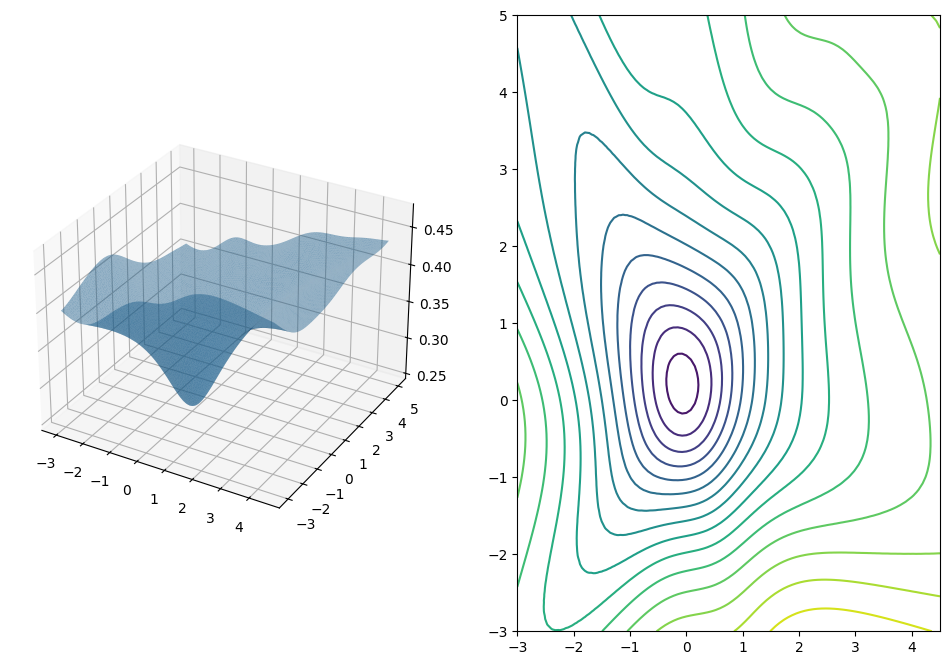

In [128]:
alphas = np.linspace( - 3, real_alpha + 3, 101)
betas = np.linspace( - 3, real_beta + 3, 101)
df_norm = get_error_plot_sigmoid(alphas, betas, l1_norm, 0.0, x, y)

fig = plt.figure(figsize=(12,8))
ax_1 = fig.add_subplot(121, projection='3d')
ax_2 = fig.add_subplot(122)
ax_1.plot_trisurf(df_norm["a"], df_norm["b"], df_norm["error"], alpha=0.5)
ax_2.tricontour(df_norm['a'], df_norm['b'], df_norm['error'], levels=15)
plt.show()

Вопрос: К чему это приводит?

Сравним также разные регрессоры для датасета с цифрами.

In [129]:
random_indices = np.random.choice(X.index, 10000, replace=False)
X_rus = X.loc[random_indices]
y_rus = y_c.loc[random_indices]

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=0)


In [130]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(penalty=None, max_iter=30)
model.fit(X_train, y_train)
print("Train accuracy is: ", model.score(X_train / 255., y_train))
print("Test accuracy is: ", model.score(X_test / 255., y_test))

Train accuracy is:  0.936375
Test accuracy is:  0.8725


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


<Axes: ylabel='Density'>

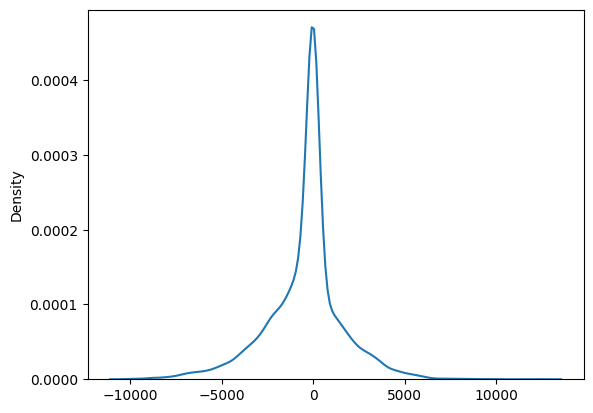

In [131]:
sns.kdeplot(model.coef_.ravel())

Train accuracy is:  0.919125
Test accuracy is:  0.8495


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


<Axes: ylabel='Density'>

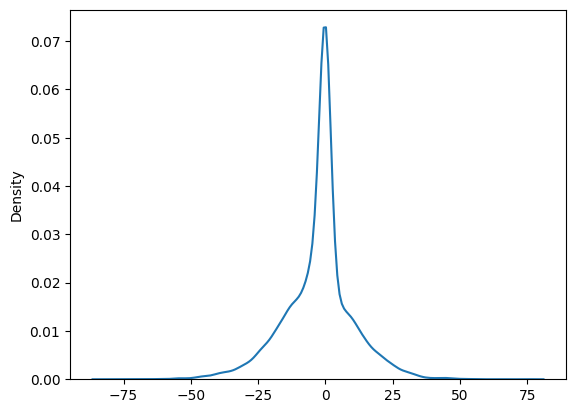

In [132]:
model = SGDClassifier(penalty="l2", alpha=0.001, max_iter=30)
model.fit(X_train, y_train)
print("Train accuracy is: ", model.score(X_train / 255, y_train))
print("Test accuracy is: ", model.score(X_test / 255, y_test))
sns.kdeplot(model.coef_.ravel())

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Train accuracy is:  0.8155
Test accuracy is:  0.793


<Axes: ylabel='Density'>

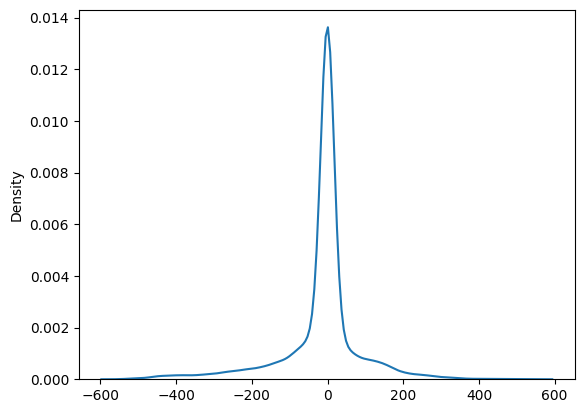

In [133]:
model = SGDClassifier(penalty="l1", alpha=0.1, max_iter=30)
model.fit(X_train, y_train)
print("Train accuracy is: ", model.score(X_train, y_train))
print("Test accuracy is: ", model.score(X_test, y_test))
sns.kdeplot(model.coef_.ravel())

Train accuracy is:  0.932625
Test accuracy is:  0.857


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


<Axes: ylabel='Density'>

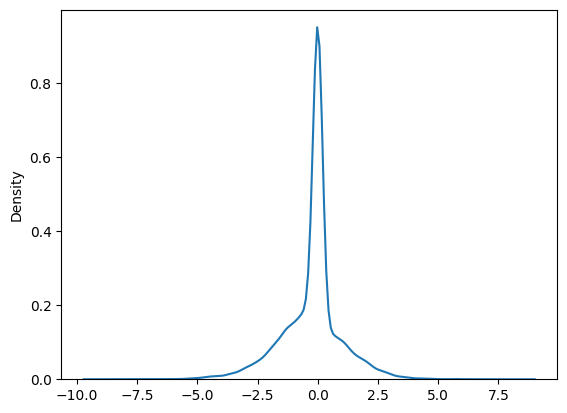

In [134]:
model = SGDClassifier(penalty="elasticnet", alpha=0.01, max_iter=30)
model.fit(X_train, y_train)
print("Train accuracy is: ", model.score(X_train, y_train))
print("Test accuracy is: ", model.score(X_test, y_test))
sns.kdeplot(model.coef_.ravel())

Рассмотрим, что будет, если использовать функцию квадратичной ошибки

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Train accuracy is:  0.122375
Test accuracy is:  0.1105


<Axes: ylabel='Density'>

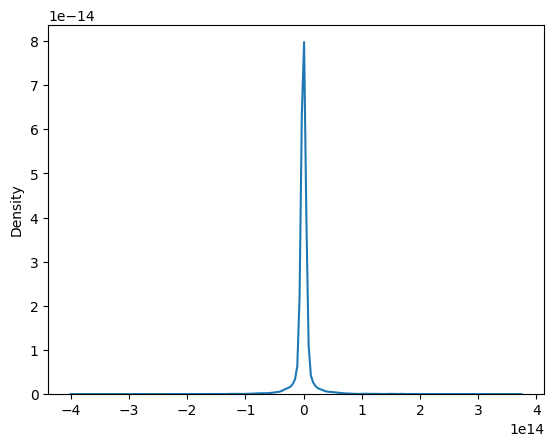

In [135]:
model = SGDClassifier(penalty="l1", alpha=0.01, max_iter=200, loss="squared_error")
model.fit(X_train, y_train)
print("Train accuracy is: ", model.score(X_train, y_train))
print("Test accuracy is: ", model.score(X_test, y_test))
sns.kdeplot(model.coef_.ravel())


## Дополнительная секция. Lars
Least angle regrssion (LARS) — это алгоритм регрессии для многомерных данных, разработанный Брэдли Эфроном, Тревором Хасти, Иэном Джонстоном и Робертом Тибширани (он же автор Lasso). LARS немного похож на PCA. На каждом этапе он находит признак, наиболее коррелирующий с целевой переменной. Когда существует несколько признаков, имеющих одинаковую корреляцию, вместо продолжения вдоль одного признака, процесс продолжается в направлении, равноугольном между ними.

- Он численно эффективен при p >> n.
- В вычислительном отношении он так же быстр, как и последовательный выбор признаков, и имеет тот же порядок сложности, что и обычный метод наименьших квадратов.
- Он создает полный кусочно-линейный путь решения, который полезен при перекрестной проверке или аналогичных попытках настройки модели.
- Если два признака почти одинаково коррелируют с целью, то их коэффициенты должны увеличиваться примерно с одинаковой скоростью. При этом алгоритм является более стабильным, чем прямой выбор признаков.
Однако, поскольку LARS основан на итеративной переработке ошибок, он может оказаться особенно чувствительным к влиянию шума. Эта проблема подробно обсуждается Вейсбергом в дискуссионном разделе книги Эфрона и др. (2004).


In [136]:
data = load_diabetes()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Train r2 is:  0.5461504831608737
Test r2  is:  0.34017713935849325


<Axes: ylabel='Density'>

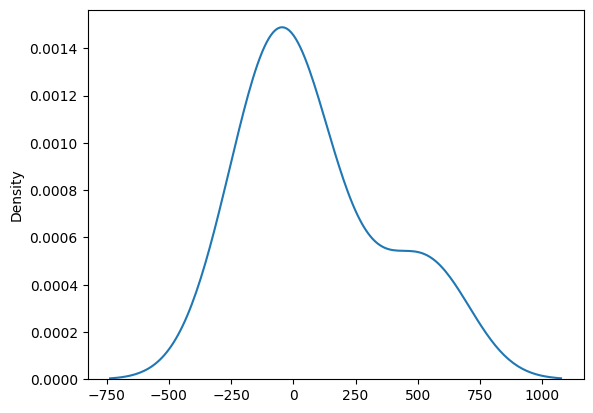

In [137]:
from sklearn.linear_model import lars_path, LassoLars, Lars
from sklearn import metrics
model = LassoLars(alpha=0.1)
model.fit(X_train, y_train)
print("Train r2 is: ", model.score(X_train, y_train))
print("Test r2  is: ", model.score(X_test, y_test))
sns.kdeplot(model.coef_.ravel())


Train r2 is:  0.4896064317036356
Test r2  is:  0.3208034673245279


<Axes: ylabel='Density'>

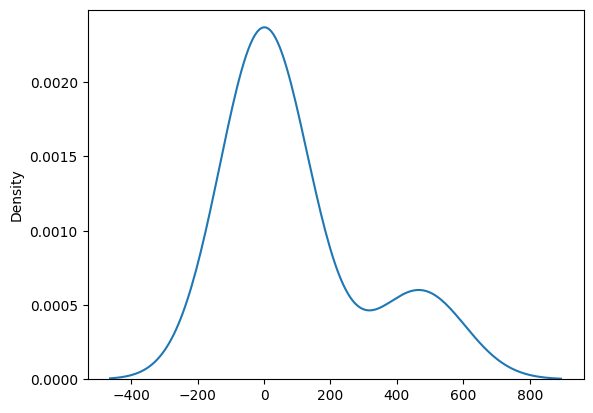

In [138]:
from sklearn.linear_model import lars_path, LassoLars, Lars
from sklearn import metrics
model = LassoLars(alpha=0.5)
model.fit(X_train, y_train)
print("Train r2 is: ", model.score(X_train, y_train))
print("Test r2  is: ", model.score(X_test, y_test))
sns.kdeplot(model.coef_.ravel())


А как понять, какие признаки в результате важны, а какие нет?

In [139]:
np.nonzero(model.coef_)

(array([2, 3, 6, 8]),)

Вопрос: а какие признаки отберут другие методы?

Train r2 is:  0.5124107806886917
Test r2  is:  0.3566824234353274


<Axes: ylabel='Density'>

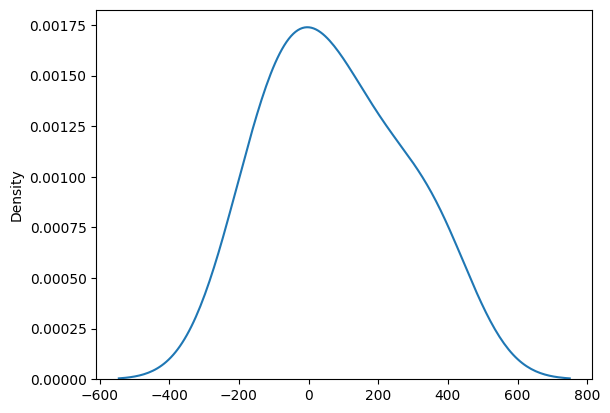

In [140]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.5)
model.fit(X_train, y_train)
print("Train r2 is: ", model.score(X_train, y_train))
print("Test r2  is: ", model.score(X_test, y_test))
sns.kdeplot(model.coef_.ravel())


С помощью Lars можно также посмотреть на "пути" переменных при уменьшении степени регуляризации. Так можно выбрать, например, l1 регуляризацию с необходимым уровнем спарсности/точности

Computing regularization path using the LARS ...
.

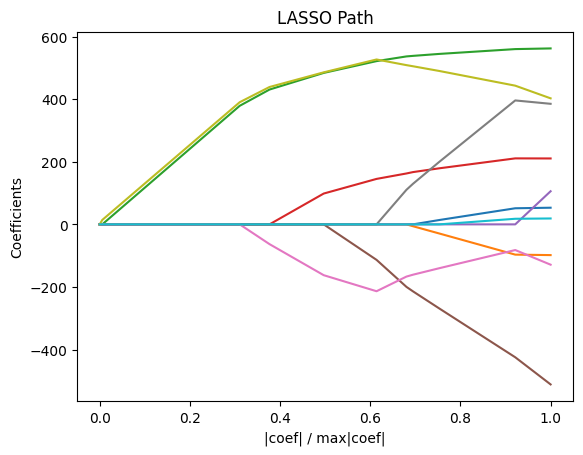

In [141]:
print("Computing regularization path using the LARS ...")
_, _, coefs = lars_path(X_train, y_train, method="lar", verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
#plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.show()